<a href="https://colab.research.google.com/github/SasikiranJ/Mini_Project/blob/master/Mini_Project_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing modules for google drive access
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authentiating with google drive using credentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Loading data and images data(.npy numpy arrays)
data = drive.CreateFile({'id': '1IjPMJwqTnBqudAknbwpAn558uTvi0BmT'})
#Creating reference of training image data using Id of file in Gdrive
train_bottle = drive.CreateFile({'id' : '1cbB6IA5vk8zoy1JgR23QLD88LvJk6Ps_'})
#Creating reference of testing image data using Id of file in Gdrive
test_bottle = drive.CreateFile({'id' : '1tSI9oO7MrkpcF7ZJA3JK5w4BHprNFJv1'})
#Creating reference of validation image data using Id of file in Gdrive
val_bottle = drive.CreateFile({'id' : '1BErplb3uBqEXyhf2VvJbMwrepsObGqQ7'})

In [0]:
#Loading data from google drive with specified names(no need to be same name as in Gdrive)
data.GetContentFile('OCT.zip')
train_bottle.GetContentFile('bottleneck_features_train.npy')
test_bottle.GetContentFile('bottleneck_features_test.npy')
val_bottle.GetContentFile('bottleneck_features_validation.npy')


In [0]:
# unzipping data file
!unzip OCT.zip

In [0]:
#Loading all modules required for loading PreTrained model,building feature extractor and classifier
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential,load_model
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras.layers import LeakyReLU
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint



In [0]:
#Desired dimensions for VGG16 model
img_width, img_height = 224,224  
   
#Create a bottleneck file(To save model)
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our dataset folders
train_data_dir = 'OCT/train'  
validation_data_dir = 'OCT/val'  
test_data_dir = 'OCT/test'
   
#specifying number of epochs to train top model  
epochs = 30 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50

In [0]:
#Loading Pre-Trained model from keras application package
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

In [0]:
#Class used to generate image data from folder of images
datagen = ImageDataGenerator(rescale=1. / 255)

In [0]:
#Generating data from Training Images folder
'''start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

In [0]:
#Generating data from validation Images folder
'''start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 32 images belonging to 4 classes.
Time:  0:00:03.437008


In [0]:
#Generating data from Testing Images folder
'''start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 1000 images belonging to 4 classes.
Time:  0:00:09.854932


In [12]:
#Assigning labels or classes to image data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 108277 images belonging to 4 classes.


In [13]:
#Labels for validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes) 

Found 32 images belonging to 4 classes.


In [14]:
#Labels for testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1000 images belonging to 4 classes.


In [67]:
#Specifying our own model or architecture of neural nets
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))
 
model.add(Dense(100)) 
model.add(LeakyReLU(alpha = 0.3)) 

model.add(Dropout(0.5))  

model.add(Dense(50))
model.add(LeakyReLU(alpha = 0.3))

model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

# Compiling model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  
# Defining callbacks to use early-stopping method for reducing computation after there is no improvement 
callbacks = [EarlyStopping(monitor='val_loss', patience=10,verbose=1,mode='auto'),
             ModelCheckpoint(filepath=top_model_weights_path, monitor='val_loss',verbose=1, save_best_only=True)]

#Fitting our model with training data and validation data
history = model.fit(train_data, train_labels,
      epochs=35,  
      batch_size=batch_size,
      callbacks= callbacks,  
      validation_data=(validation_data, validation_labels))  



Train on 108277 samples, validate on 32 samples
Epoch 1/35
108277/108277 [==============================] - 26s 244us/step - loss: 0.5176 - acc: 0.8255 - val_loss: 0.6732 - val_acc: 0.7500

Epoch 00001: val_loss improved from inf to 0.67316, saving model to bottleneck_fc_model.h5
Epoch 2/35
108277/108277 [==============================] - 24s 220us/step - loss: 0.3808 - acc: 0.8771 - val_loss: 0.6048 - val_acc: 0.6875

Epoch 00002: val_loss improved from 0.67316 to 0.60482, saving model to bottleneck_fc_model.h5
Epoch 3/35
108277/108277 [==============================] - 24s 220us/step - loss: 0.3457 - acc: 0.8901 - val_loss: 0.5713 - val_acc: 0.8125

Epoch 00003: val_loss improved from 0.60482 to 0.57134, saving model to bottleneck_fc_model.h5
Epoch 4/35
108277/108277 [==============================] - 24s 220us/step - loss: 0.3240 - acc: 0.8978 - val_loss: 0.5954 - val_acc: 0.8125

Epoch 00004: val_loss did not improve from 0.57134
Epoch 5/35
108277/108277 [==========================

In [61]:
#Loading optimal model file which gives good accuracy
model_opt = load_model("bottleneck_fc_model.h5")
model_opt.summary()
#Checking accuracy
(eval_loss, eval_accuracy) = model_opt.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)


print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss)) 

print(model_opt.get_losses_for(train_data))



Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               2508900   
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 50)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)               

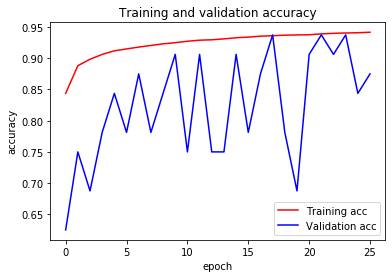

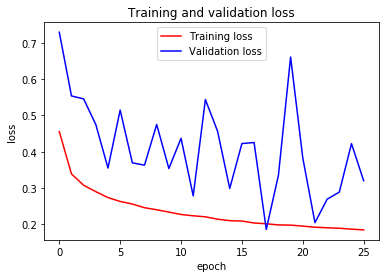

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [62]:
model_opt.evaluate(test_data, test_labels)

1000/1000 [==============================] - 0s 138us/step


[0.2729304414317012, 0.901]

In [0]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [0]:
def test_single_image(path):
    clas = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model_opt.predict_proba(bt_prediction)
    for idx, clas, x in zip(range(0,4), clas , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, clas, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model_opt.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [0]:
path = "/content/out_of_sample/DRUSEN.jpg"

[INFO] loading and preprocessing image...
ID: 0, Label: CNV 97.32%
ID: 1, Label: DME 0.0%
ID: 2, Label: DRUSEN 2.68%
ID: 3, Label: NORMAL 0.0%
Final Decision:
.
..
...
ID: 0, Label: CNV


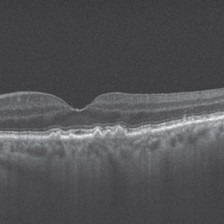

In [66]:
test_single_image(path)

[INFO] loading and preprocessing image...
ID: 0, Label: CNV 99.51%
ID: 1, Label: DME 0.0%
ID: 2, Label: DRUSEN 0.48%
ID: 3, Label: NORMAL 0.0%
Final Decision:
.
..
...
ID: 0, Label: CNV


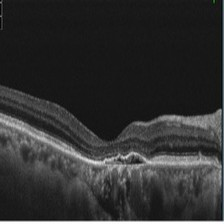

In [0]:
test_single_image("/content/out_of_sample/CNV.jpg")

[INFO] loading and preprocessing image...
ID: 0, Label: CNV 0.0%
ID: 1, Label: DME 100.0%
ID: 2, Label: DRUSEN 0.0%
ID: 3, Label: NORMAL 0.0%
Final Decision:
.
..
...
ID: 1, Label: DME


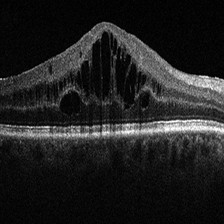

In [0]:
test_single_image("/content/out_of_sample/DME.jpg")

[INFO] loading and preprocessing image...
ID: 0, Label: CNV 0.0%
ID: 1, Label: DME 0.0%
ID: 2, Label: DRUSEN 0.0%
ID: 3, Label: NORMAL 100.0%
Final Decision:
.
..
...
ID: 3, Label: NORMAL


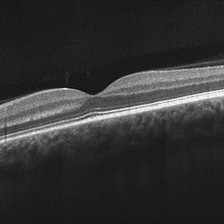

In [35]:
test_single_image("/content/out_of_sample/normal.jpg")